In [1]:
%autosave 300
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.functional import accuracy, f1_score, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Seed set to 42


42

In [3]:
# downloading the toxic-comment-classification-challenge
!gdown --id 1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr

/anaconda/envs/finetune_env/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr
To: /mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/Abi_GenAI_Sessions/notebooks/finetuning/toxic_comments.csv
100%|██████████████████████████████████████| 68.8M/68.8M [00:00<00:00, 86.2MB/s]


In [4]:
df = pd.read_csv("toxic_comments.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
# splitting the data:
train_df, val_df = train_test_split(df, test_size=0.05)
train_df.shape, val_df.shape

((151592, 8), (7979, 8))

<Axes: >

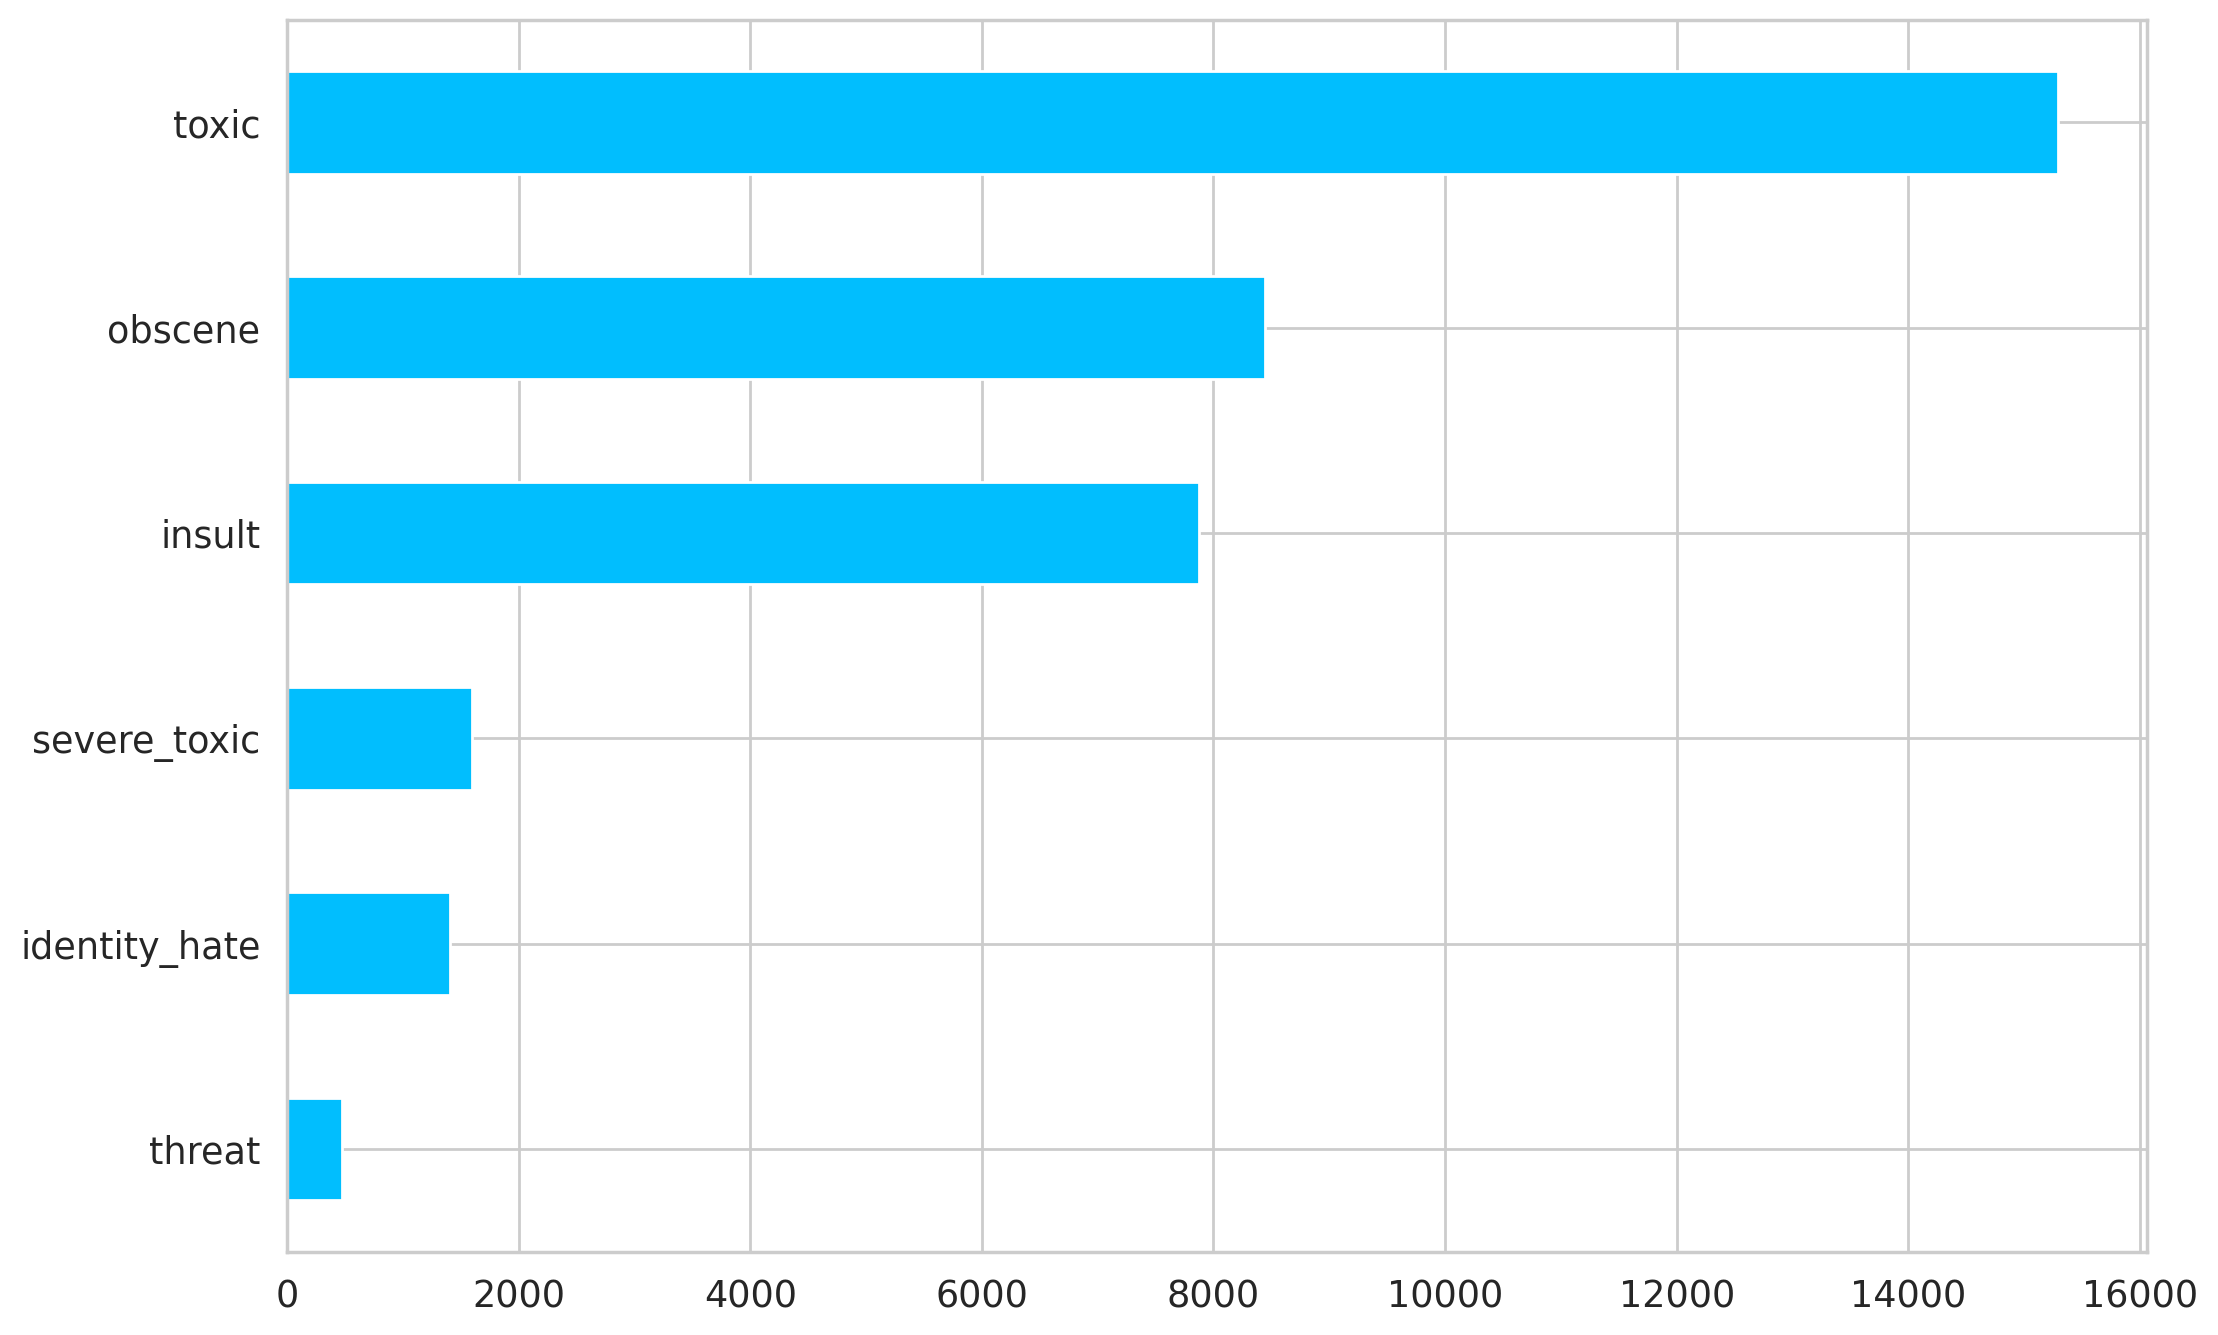

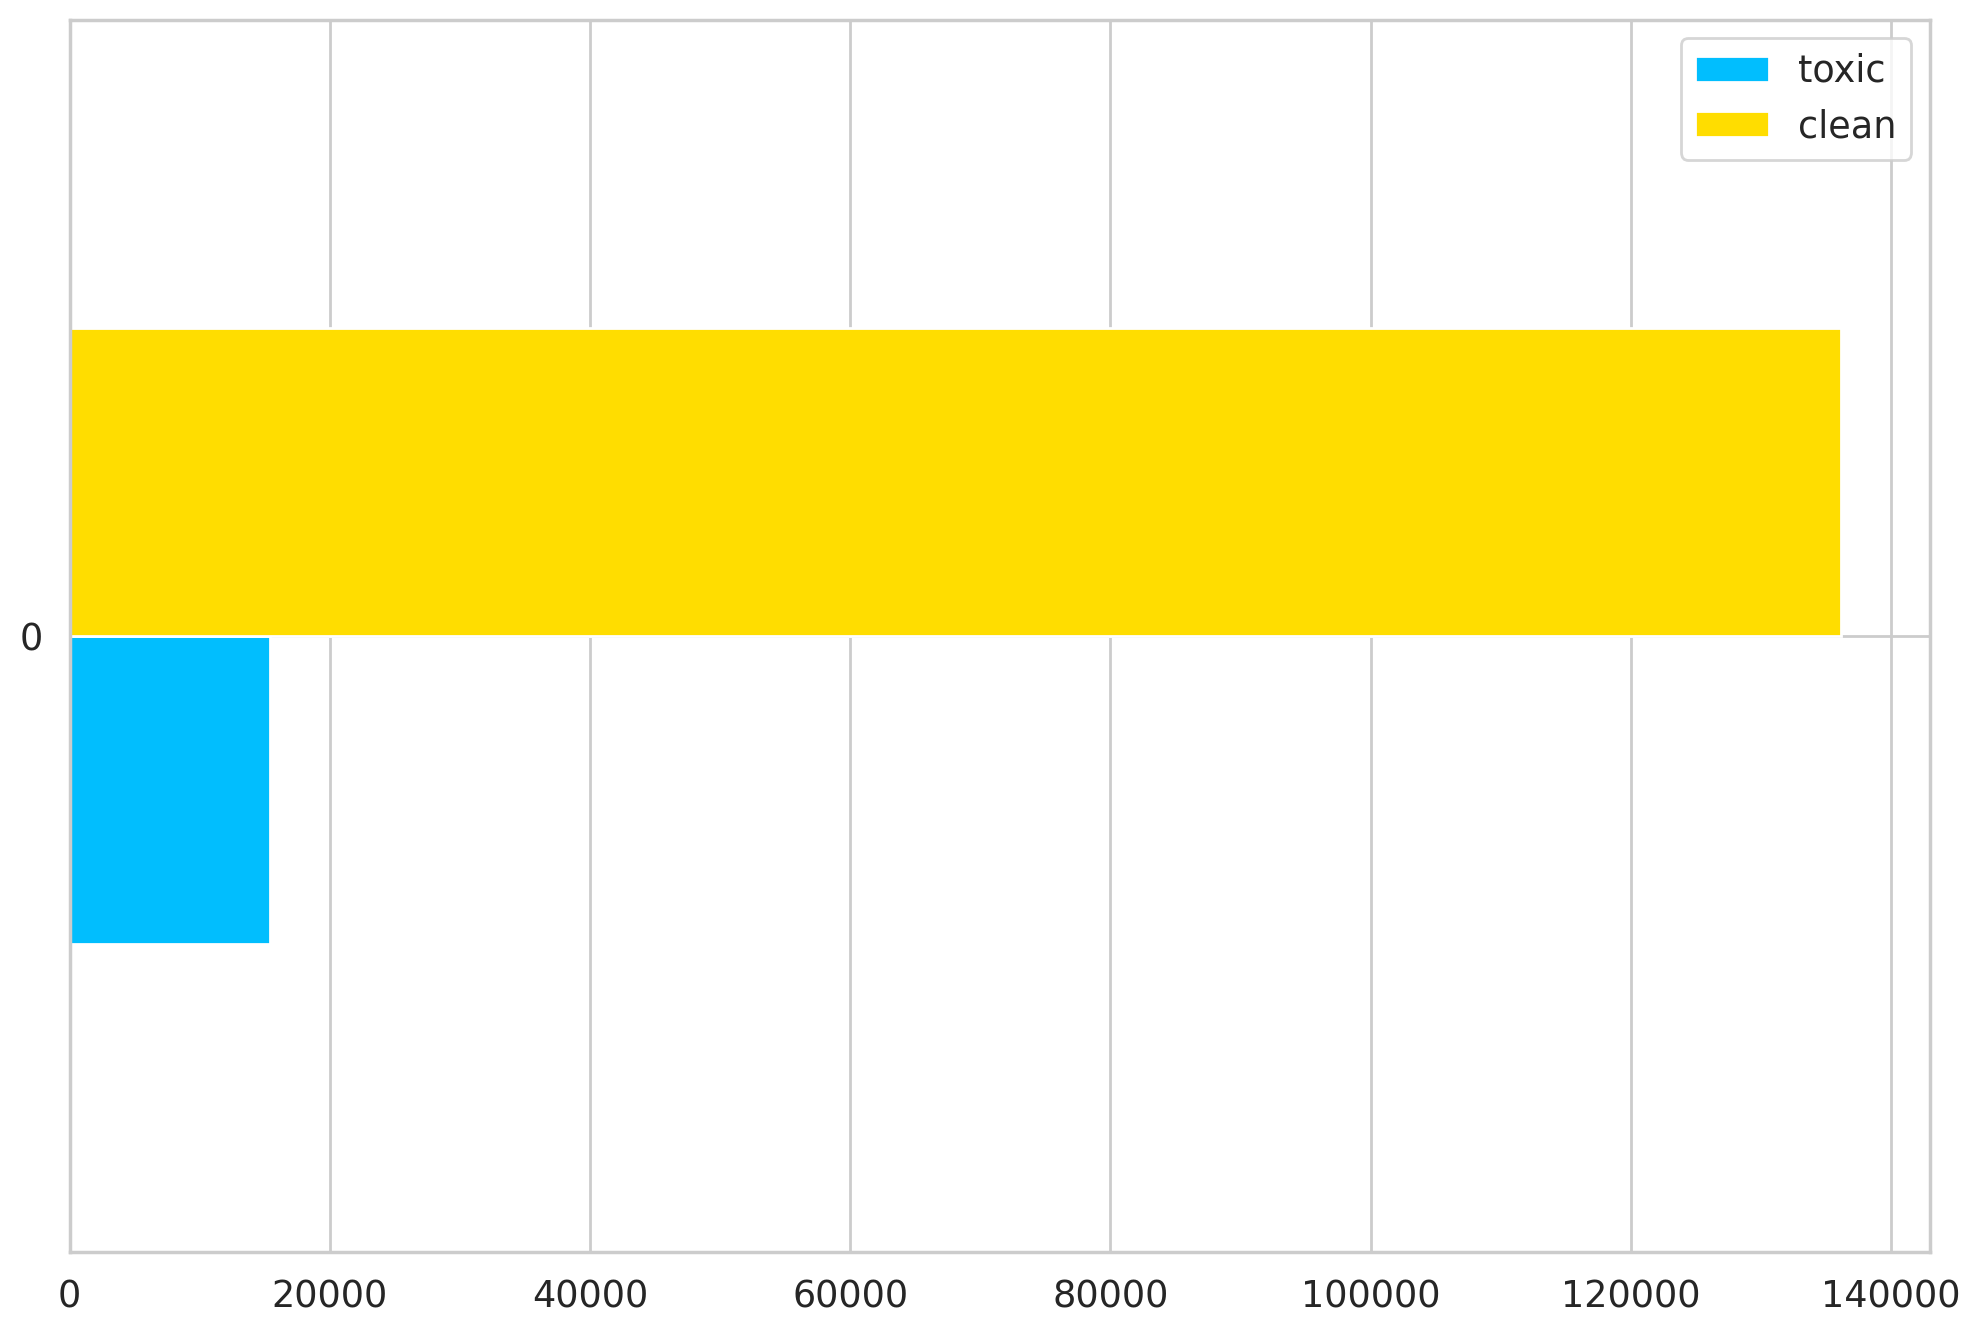

In [6]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh")
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(toxic=[len(train_toxic)], clean=[len(train_clean)])).plot(kind="barh")

In [7]:
train_df = pd.concat([train_toxic, train_clean.sample(15_000)])

train_df.shape, val_df.shape

((30427, 8), (7979, 8))

Tokenization
We need to convert the raw text into a list of tokens. For that, we'll use the built-in BertTokenizer:

In [8]:
BERT_MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [9]:
MAX_TOKEN_COUNT = 256

In [10]:
class ToxicCommentsDataset(Dataset):
    """
    We'll wrap the tokenization process in a PyTorch Dataset, along with converting the labels to tensors:
    """

    def __init__(
        self, data: pd.DataFrame, tokenizer: BertTokenizer, max_token_len: int = 128
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        comment_text = data_row.comment_text
        labels = data_row[LABEL_COLUMNS]

        encoding = self.tokenizer.encode_plus(
            comment_text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return dict(
            comment_text=comment_text,
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            labels=torch.FloatTensor(labels),
        )

In [11]:
train_dataset = ToxicCommentsDataset(train_df, tokenizer, max_token_len=MAX_TOKEN_COUNT)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [12]:
sample_item["comment_text"]

'Hi, ya fucking idiot. ^_^'

In [13]:
sample_item["labels"]

tensor([1., 0., 1., 0., 1., 0.])

In [14]:
sample_item["input_ids"].shape

torch.Size([256])

Loading the bert model

In [15]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

In [16]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(torch.Size([8, 256]), torch.Size([8, 256]))

In [17]:
# sample model working:
# The 768 dimension comes from the BERT hidden size
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 256, 768]), torch.Size([8, 768]))

We'll wrap our custom dataset into a LightningDataModule: a way to organize the data-related hooks in a PyTorch Lightning model. This will allow us to easily switch between datasets and even datasets and data augmentations.

In [18]:
class ToxicCommentDataModule(pl.LightningDataModule):
    """
    We'll wrap the PyTorch Dataset in a PyTorch Lightning DataModule:
    """

    def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = ToxicCommentsDataset(
            self.train_df, self.tokenizer, self.max_token_len
        )

        self.test_dataset = ToxicCommentsDataset(
            self.test_df, self.tokenizer, self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=2)

In [19]:
N_EPOCHS = 10
BATCH_SIZE = 32

data_module = ToxicCommentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)


In [20]:
data_module.test_df.shape, data_module.train_df.shape

((7979, 8), (30427, 8))

Our model will use a pre-trained BertModel and a linear layer to convert the BERT representation to a classification task. We'll pack everything in a LightningModule:

In [21]:
class ToxicCommentTagger(pl.LightningModule):

    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def on_train_epoch_end(self, outputs):

        labels = []
        predictions = []
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)

        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)

        for i, name in enumerate(LABEL_COLUMNS):
            class_roc_auc = auroc(predictions[:, i], labels[:, i])
            self.logger.experiment.add_scalar(
                f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch
            )

    def configure_optimizers(self):

        optimizer = AdamW(self.parameters(), lr=2e-5)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps,
        )

        return dict(
            optimizer=optimizer, lr_scheduler=dict(scheduler=scheduler, interval="step")
        )

In [22]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
print(total_training_steps)

9500


In [23]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(1900, 9500)

In [24]:
# training the model:
model = ToxicCommentTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

In [25]:
from sklearn import metrics

In [26]:
# adding checkpoint and early stopping:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [27]:
# callbacks for early stopping and logging:
logger = TensorBoardLogger("lightning_logs", name="toxic-comments")
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [28]:
trainer = pl.Trainer(
    logger=logger,
    callbacks=[early_stopping_callback, checkpoint_callback],
    max_epochs=N_EPOCHS,
    deterministic=True,
    devices="auto",
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [29]:
trainer.fit(model, data_module)

2024-09-25 11:17:45.771118: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 11:17:45.771168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 11:17:45.772015: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 11:17:45.777401: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 11:17:46.537475: W tensorflow/compiler/tf2

Sanity Checking: |                                                                                            …

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training: |                                                                                                   …

In [ ]:
trainer.test()

In [ ]:
trained_model = ToxicCommentTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

In [ ]:
test_comment = "Hi, I'm Meredith and I'm an alch... good at supplier relations"

encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

In [ ]:
THRESHOLD = 0.5

test_comment = "You are such a loser! You'll regret everything you've done to me!"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  if prediction < THRESHOLD:
    continue
  print(f"{label}: {prediction}")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = ToxicCommentsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

In [ ]:
accuracy(predictions, labels, threshold=THRESHOLD)

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0
))

In [ ]:
References:
* https://colab.research.google.com/drive/14Ea4lIzsn5EFvPpYKtWStXEByT9qmbkj?usp=sharing#scrollTo=0muhafskBrYH
* https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/